<a href="https://colab.research.google.com/github/AndrewDavidRatnam/Feature-_Engineering_Bookcamp-/blob/main/Feature_Engineering_BookCamp_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 4.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import time


In [71]:
def simple_grid_search(x_train, y_train, x_test, y_test, feature_engineering_pipeline):
  params = {
      "max_depth": [10,None],
      "n_estimators": [10,50,100,500],
      "criterion":["gini","entropy"]
  }

  base_model = ExtraTreesClassifier()

  model_grid_search = GridSearchCV(base_model, param_grid=params, cv=3)
  start_time = time.time()
  if feature_engineering_pipeline:
    parsed_x_train = feature_engineering_pipeline.fit_transform(x_train, y_train)
    parsed_x_test = feature_engineering_pipeline.transform(x_test)
  else:
    parsed_x_train = x_train
    parsed_x_test = x_test

  parse_time = time.time()
  print(f"Parsing took {(parse_time - start_time):.2f}")

  model_grid_search.fit(parsed_x_train,y_train)
  fit_time = time.time()
  print(f"Training time {(fit_time - start_time):.2f} seconds")

  best_model = model_grid_search.best_estimator_

  print(classification_report(y_true=y_test, y_pred=best_model.predict(parsed_x_test)))
  end_time = time.time()

  print(f"Overall data transforming and training time {(end_time - start_time)}")

  return best_model



# Healthcare:Diagnosing COVID-19

Binary Classification :-
- COVID-19—A disease caused by SARS-CoV-2
- H1N1—A subtype of influenza

Our plan for our projects will generally follow these steps:

1. First we will download/ingest our data and do initial preparations, such as
renaming any columns, etc.
2. Perform some exploratory data analysis to understand what data columns we
have and assign data levels to each column.
3. Split our data into train and test sets, so we can train our models on the training set and get a less biased set of metrics by evaluating our model on the test set.
4. Set up an ML pipeline with our feature engineering algorithms along with a learning algorithm, such as logistic regression, random forest, etc.
5. Perform cross-validation on our training set to find the best set of parameters for our pipeline.
6. Fit our best model on the entire training set, evaluate it on our testing set, and print our ML pipeline’s performance metrics.
7. Repeat steps 4–6 using different feature engineering techniques to see how well our feature engineering efforts are paying off.

In [5]:
covid_flu = pd.read_csv("covid_flu.csv")
covid_flu.head()

,Diagnosis,InitialPCRDiagnosis,Age,Sex,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue
0,H1N1,NaN,67.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,No,NaN,38.111111,No
1,H1N1,NaN,29.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H1N1,NaN,22.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H1N1,NaN,20.0,F,NaN,NaN,NaN,NaN,NaN,NaN,immuno,NaN,NaN,Yes,Yes,NaN,No,NaN,36.555556,Yes
4,H1N1,NaN,21.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

In [6]:
covid_flu.isnull().mean() *100

,0
Diagnosis,0.000000
InitialPCRDiagnosis,92.982456
Age,1.889339
Sex,5.128205
neutrophil,93.049933
serumLevelsOfWhiteBloodCell,89.811066
lymphocytes,89.473684
CReactiveProteinLevels,90.755735
DurationOfIllness,94.129555
CTscanResults,89.271255


In [7]:
covid_flu['Diagnosis'].value_counts(normalize=True) * 100

,proportion
Diagnosis,
H1N1,72.334683
COVID19,27.665317


In [8]:
covid_flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Diagnosis                    1482 non-null   object 
 1   InitialPCRDiagnosis          104 non-null    object 
 2   Age                          1454 non-null   float64
 3   Sex                          1406 non-null   object 
 4   neutrophil                   103 non-null    float64
 5   serumLevelsOfWhiteBloodCell  151 non-null    float64
 6   lymphocytes                  156 non-null    float64
 7   CReactiveProteinLevels       137 non-null    object 
 8   DurationOfIllness            87 non-null     float64
 9   CTscanResults                159 non-null    object 
 10  RiskFactors                  209 non-null    object 
 11  GroundGlassOpacity           93 non-null     object 
 12  Diarrhea                     450 non-null    object 
 13  Fever             

## Feature Improvement

How will improve the features:-
- imputing data
- scaling/normalizing

### Imputing missing quantitative data

In [9]:
numeric_types = ['float16', 'float32', 'float64', 'int16', 'int32', 'int64']
numerical_columns = covid_flu.select_dtypes(include=numeric_types).columns.tolist()
numerical_columns

['Age',
 'neutrophil',
 'serumLevelsOfWhiteBloodCell',
 'lymphocytes',
 'DurationOfIllness',
 'Temperature']

Mean/Median Imputation

In [10]:
from sklearn.impute import SimpleImputer
num_impute = SimpleImputer(strategy='mean')
print(covid_flu["lymphocytes"].head())
print()
print(f"Mean is of column {covid_flu["lymphocytes"].mean():.4f}")
print()
print(num_impute.fit_transform(covid_flu[['lymphocytes']]) [:5])

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: lymphocytes, dtype: float64

Mean is of column 1.8502

[[1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]]


Arbitary value imputation

Used when we want our data to contain some value, but some arbitary value that does not fall in the range of the normal values. Usefull trees, but other models this may prove dangerous

In [11]:
arbitary_imputer = SimpleImputer(strategy='constant', fill_value=999)
arbitary_imputer.fit_transform(covid_flu[numerical_columns])

array([[ 67.        , 999.        , 999.        , 999.        ,
        999.        ,  38.11111111],
       [ 29.        , 999.        , 999.        , 999.        ,
        999.        , 999.        ],
       [ 22.        , 999.        , 999.        , 999.        ,
        999.        , 999.        ],
       ...,
       [  3.        , 999.        ,  15.        , 999.        ,
        999.        , 999.        ],
       [  4.        , 999.        ,   6.6       , 999.        ,
        999.        , 999.        ],
       [  6.        , 999.        ,   5.3       , 999.        ,
        999.        , 999.        ]])

End-of-Tail Imputation

Used to fill missing values based on the distribution of the feature

arithmetic mean + 3 * standard deviation

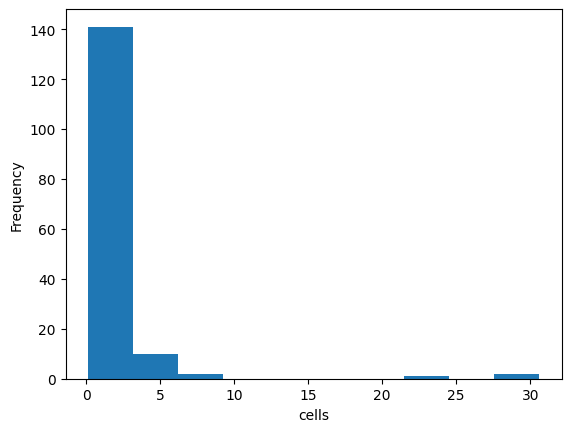

In [12]:
covid_flu["lymphocytes"].plot(kind="hist", xlabel='cells')
plt.show()

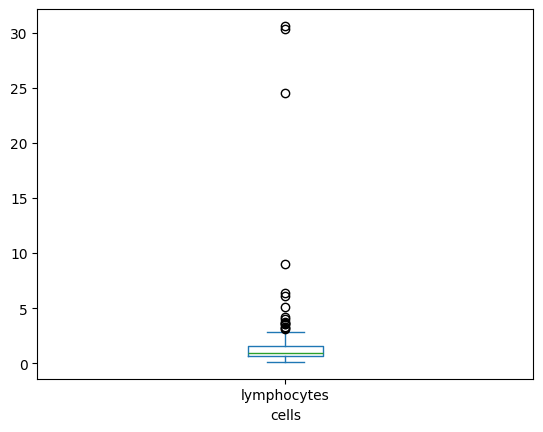

In [13]:
covid_flu["lymphocytes"].plot(kind="box", xlabel='cells')
plt.show()

In [14]:
import feature_engine

Error in Book
```
from feature_engine.imputation import EndOfTailImputer
EndOfTailImputer().fit_transform(covid_flu[['lymphocytes']]).plot(
title='Lymphocytes (Imputed)', kind='hist', xlabel='cells/µL')
```

<Axes: ylabel='Frequency'>

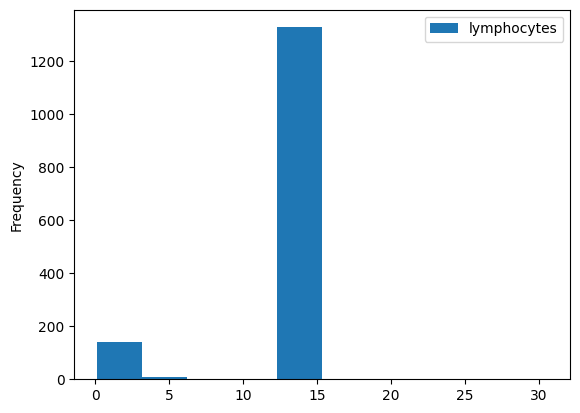

In [15]:
from feature_engine.imputation import EndTailImputer

EndTailImputer().fit_transform(covid_flu[["lymphocytes"]]).plot(kind="hist")

### Imputing missing qualitative data

In [16]:
categorical_types = ['O'] #object types
categorical_columns = (
    covid_flu.select_dtypes(include="object")
    .columns.tolist()
)
categorical_columns

['Diagnosis',
 'InitialPCRDiagnosis',
 'Sex',
 'CReactiveProteinLevels',
 'CTscanResults',
 'RiskFactors',
 'GroundGlassOpacity',
 'Diarrhea',
 'Fever',
 'Coughing',
 'ShortnessOfBreath',
 'SoreThroat',
 'NauseaVomitting',
 'Fatigue']

In [17]:
categorical_columns.remove('Diagnosis')


In [18]:
for col in categorical_columns:
  print("="*10)
  print(covid_flu[col].value_counts(dropna=False))
  print("="*10)
  print("****"*10)


InitialPCRDiagnosis
NaN    1378
Yes     100
No        4
Name: count, dtype: int64
****************************************
Sex
M      748
F      658
NaN     76
Name: count, dtype: int64
****************************************
CReactiveProteinLevels
NaN     1345
0.5        3
15         3
8          3
111        2
        ... 
33.2       1
85         1
28.4       1
0.7        1
0.6        1
Name: count, Length: 121, dtype: int64
****************************************
CTscanResults
NaN    1323
Yes     144
No       15
Name: count, dtype: int64
****************************************
RiskFactors
NaN                                      1273
asthma                                     36
immuno                                     21
pneumonia                                  21
diabetes                                   16
                                         ... 
chronic obstructive pulmonary disease       1
coronary artery disease                     1
Hypertension                  

In [19]:
# covid_flu["RiskFactors"].nunique()
#covid_flu["RiskFactors"].value_counts().plot(kind="bar")
covid_flu["RiskFactors"].unique()


array([nan, 'immuno', 'Renal Disease, athero',
       'chronic, diabetes, athero', 'diabetes',
       'asthma, congestive, diabetes', 'diabetes, Renal Disease',
       'chronic', 'asthma', 'asthma, diabetes', 'athero',
       'asthma, chronic, diabetes', 'diabetes, athero', 'asthma, chronic',
       'asthma, immuno', 'congestive, diabetes, Renal Disease',
       'asthma, Renal Disease', 'Renal Disease',
       ' Chronic Liver Disorder, chronic', 'Heart Disease',
       'Chronic Endrocrine Disorder, chronic', 'immuno, chronic',
       'hematological disease, immuno, Renal Disease',
       'Chronic Neurological Disorders', 'chronic, diabetes',
       'chronic, immuno', 'diabetes, obesity',
       'asthma, respiratory disease',
       'asthma, respiratory disease, hematological disease',
       'respiratory disease', 'pneumonia', 'gastrectomy', 'lung cancer',
       'HepB', 'obesity', 'Fatty Liver', 'Hypertension',
       'diabetes, Hypertension',
       'Hypertension, Heart Disease, chro

Clearly see that we can remove and and then bin it or add a list to dataframe

In [20]:
covid_flu["Female"] = covid_flu["Sex"] == 'F'

In [21]:
covid_flu = covid_flu.drop(columns=["Sex"])
covid_flu


,Diagnosis,InitialPCRDiagnosis,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue,Female
0,H1N1,NaN,67.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,No,NaN,38.111111,No,True
1,H1N1,NaN,29.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,H1N1,NaN,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,H1N1,NaN,20.00,NaN,NaN,NaN,NaN,NaN,NaN,immuno,NaN,NaN,Yes,Yes,NaN,No,NaN,36.555556,Yes,True
4,H1N1,NaN,21.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,COVID19,NaN,1.40,NaN,9.2,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1478,COVID19,NaN,0.83,NaN,14.8,NaN,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1479,COVID19,NaN,3.00,NaN,15.0,NaN,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1480,COVID19,NaN,4.00,NaN,6.6,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [22]:
covid_flu = covid_flu.replace({"Yes":True,"No":False})

In [23]:
categorical_columns.remove('Sex')
for col in categorical_columns:
  print("="*10)
  print(covid_flu[col].value_counts(dropna=False))
  print("="*10)
  print("****"*10)

InitialPCRDiagnosis
NaN      1378
True      100
False       4
Name: count, dtype: int64
****************************************
CReactiveProteinLevels
NaN     1345
0.5        3
15         3
8          3
111        2
        ... 
33.2       1
85         1
28.4       1
0.7        1
0.6        1
Name: count, Length: 121, dtype: int64
****************************************
CTscanResults
NaN      1323
True      144
False      15
Name: count, dtype: int64
****************************************
RiskFactors
NaN                                      1273
asthma                                     36
immuno                                     21
pneumonia                                  21
diabetes                                   16
                                         ... 
chronic obstructive pulmonary disease       1
coronary artery disease                     1
Hypertension                                1
hyperthyroidism                             1
Lung Disease                  

Most-Frequent category imputation

In [24]:
cat_impute = SimpleImputer(strategy="most_frequent")
print(covid_flu['Coughing'].head())
print(cat_impute.fit_transform(
    covid_flu[["Coughing"]])[:5])


0    True
1     NaN
2     NaN
3    True
4     NaN
Name: Coughing, dtype: object
[[True]
 [True]
 [True]
 [True]
 [True]]


Arbitary category imputation<br>
Same with the numerical, here we impute as false as usually doctors only list symptoms if present, not explicity state if absent

In [25]:
categorical_columns

['InitialPCRDiagnosis',
 'CReactiveProteinLevels',
 'CTscanResults',
 'RiskFactors',
 'GroundGlassOpacity',
 'Diarrhea',
 'Fever',
 'Coughing',
 'ShortnessOfBreath',
 'SoreThroat',
 'NauseaVomitting',
 'Fatigue']

In [26]:
columns_to_remove = ["RiskFactors", "CReactiveProteinLevels"]
binary_features = [col for col in categorical_columns if col not in columns_to_remove]


In [27]:
binary_features

['InitialPCRDiagnosis',
 'CTscanResults',
 'GroundGlassOpacity',
 'Diarrhea',
 'Fever',
 'Coughing',
 'ShortnessOfBreath',
 'SoreThroat',
 'NauseaVomitting',
 'Fatigue']

In [28]:
fill_false = SimpleImputer(strategy="constant", fill_value="False")
fill_false.fit_transform(covid_flu[binary_features])

array([['False', 'False', 'False', ..., False, 'False', False],
       ['False', 'False', 'False', ..., 'False', 'False', 'False'],
       ['False', 'False', 'False', ..., 'False', 'False', 'False'],
       ...,
       ['False', 'False', 'False', ..., 'False', 'False', 'False'],
       ['False', 'False', 'False', ..., 'False', 'False', 'False'],
       ['False', 'False', 'False', ..., 'False', 'False', 'False']],
      dtype=object)

## Feature construction

Manual construction of Features by transforming exisiting features

### Numerical Feature Transformation

### Constructing categorical data

#### Log transforms:
- log(1+x) incase x = 0
- strictly on postive data
- if heavy tail, then makes the data distribution more normal, as tests (chi squared logistic regression assume that the data is normally distributed)

Drawbacks:
- distorting variable distribution, which may decrease performance and also any interelated features
- changing the statistics unlike simple scaling, which changes covariance among variables, becomes an issue for methods the rely on covariance.
- are good at hiding outliers, which may mask certain issues and make it hard to deal with manually


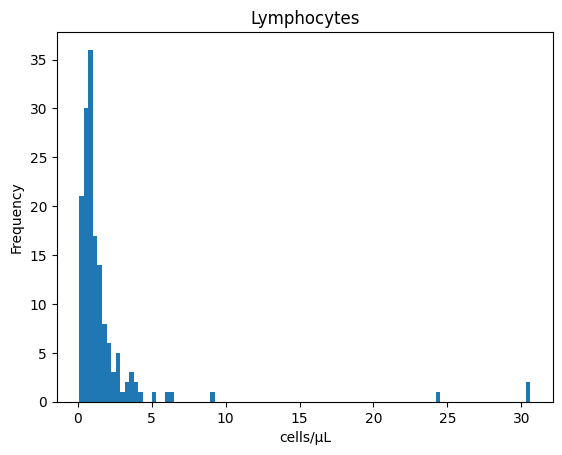

In [29]:
covid_flu['lymphocytes'].plot(title='Lymphocytes', kind='hist', xlabel='cells/µL', bins=100)
plt.show()

<Axes: title={'center': 'Lymphocytes'}, xlabel='cells/µL', ylabel='Frequency'>

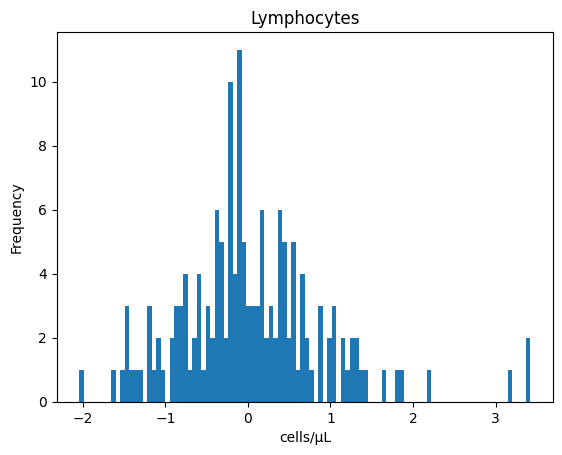

In [30]:
covid_flu['lymphocytes'].map(np.log).plot(title='Lymphocytes', kind='hist', xlabel='cells/µL', bins=100)

<Axes: title={'center': 'Lymphocytes'}, xlabel='cells/µL', ylabel='Frequency'>

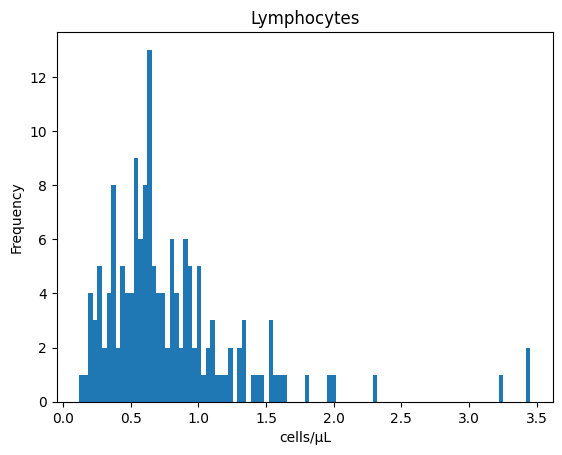

In [31]:
covid_flu['lymphocytes'].map(np.log1p).plot(title='Lymphocytes', kind='hist', xlabel='cells/µL', bins=100)

#### Box-Cox Transformations:
$ \frac{x_i^λ -1}{λ}$ or $ln(x_i)$
- tries to make the data more normal
- strictly postive data
- can use :  
  - scipy.stats.boxcox() : provides optimal lamda for $ \frac{x_i^λ -1}{λ}$
  - sklearn.preprocessing.PowerTransformer

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

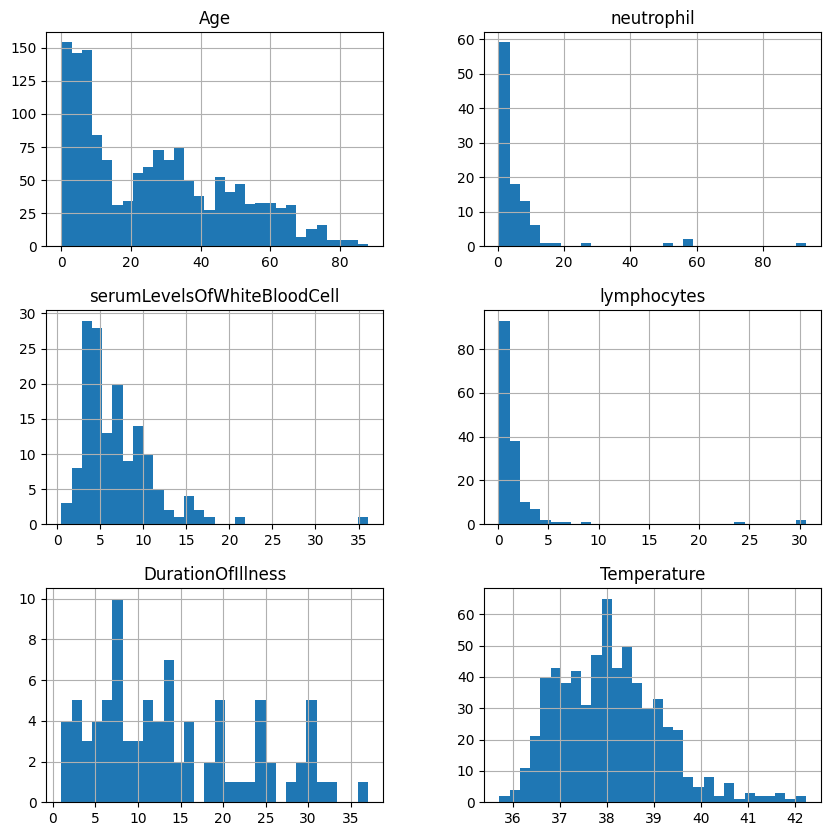

In [32]:
# covid_flu[covid_flu["Age"] == 0].head(1)
covid_flu['Age'] = covid_flu['Age'] + 0.01
pd.DataFrame(covid_flu[numerical_columns]).hist(figsize=(10,10),bins=30)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

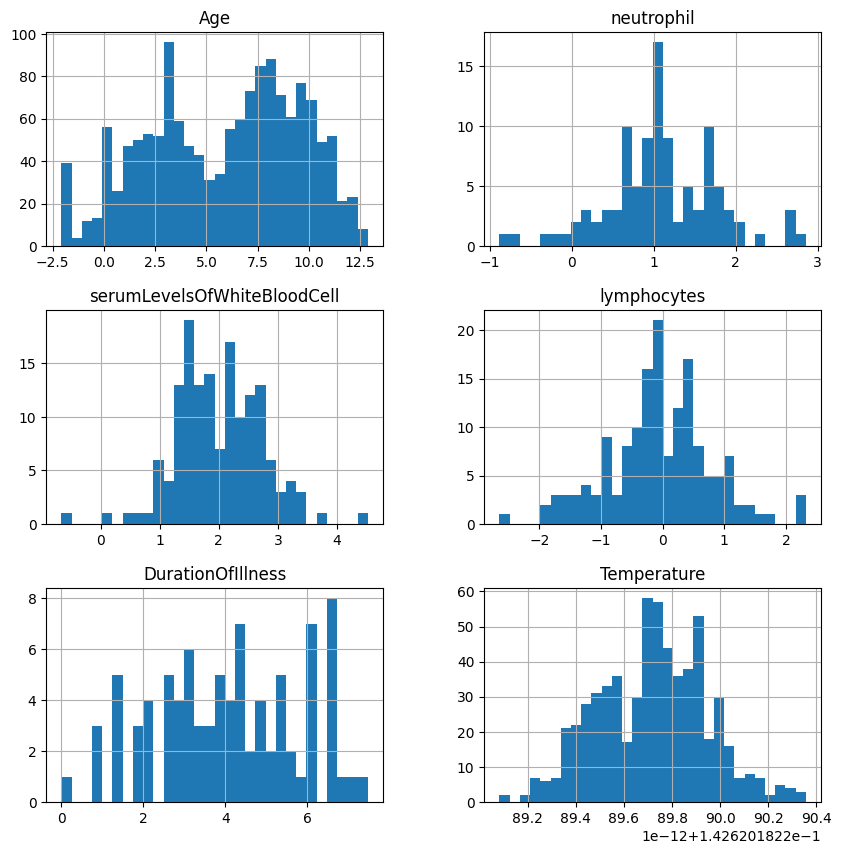

In [33]:
#sklearn preprocessing
from sklearn.preprocessing import PowerTransformer
boxcox_transform = PowerTransformer(method="box-cox", standardize=False)
pd.DataFrame(boxcox_transform.fit_transform(covid_flu[numerical_columns]),
columns=numerical_columns
).hist(figsize=(10, 10),bins=30)

In [34]:
boxcox_transform.lambdas_

array([ 0.41035252, -0.22261793,  0.12473207, -0.24415702,  0.36376994,
       -7.01163036])

#### Feature Scaling

- for any  numerical method ML algorithm so that the scales of all the features are nearly the same
- Min max
- z-score standardization


In [35]:
covid_flu[numerical_columns].describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1454.000000,103.000000,151.000000,156.000000,87.000000,628.000000
mean,26.481040,6.854078,6.885159,1.850154,13.988506,38.068312
std,21.487982,12.690131,4.346668,3.956668,9.043171,1.094468
min,0.010000,0.446000,0.500000,0.130000,1.000000,35.722222
25%,7.010000,2.160000,3.995000,0.637500,7.000000,37.222222
50%,24.010000,3.310000,5.690000,0.905500,12.000000,38.000000
75%,42.010000,6.645000,9.155000,1.605000,20.000000,38.722222
max,88.010000,93.000000,36.070000,30.600000,37.000000,42.222222


In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
pd.DataFrame(
    StandardScaler().fit_transform(covid_flu[numerical_columns]),columns=numerical_columns
).describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1.454000e+03,103.000000,1.510000e+02,1.560000e+02,8.700000e+01,6.280000e+02
mean,1.368308e-16,0.000000,-1.411674e-16,-1.708035e-17,-5.614921e-17,1.708471e-15
std,1.000344e+00,1.004890,1.003328e+00,1.003221e+00,1.005797e+00,1.000797e+00
min,-1.232324e+00,-0.507435,-1.473866e+00,-4.361482e-01,-1.444604e+00,-2.145299e+00
25%,-9.064480e-01,-0.371709,-6.671264e-01,-3.074706e-01,-7.772737e-01,-7.736770e-01
50%,-1.150359e-01,-0.280644,-2.758748e-01,-2.395187e-01,-2.211651e-01,-6.246559e-02
75%,7.229298e-01,-0.016556,5.239403e-01,-6.215921e-02,6.686088e-01,5.979450e-01
max,2.864398e+00,6.821614,6.736646e+00,7.289577e+00,2.559378e+00,3.798396e+00


In [37]:
pd.DataFrame(
    MinMaxScaler().fit_transform(covid_flu[numerical_columns]),columns=numerical_columns
).describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1454.000000,103.000000,151.000000,156.000000,87.000000,628.000000
mean,0.300807,0.069236,0.179510,0.056454,0.360792,0.360937
std,0.244182,0.137111,0.122200,0.129855,0.251199,0.168380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.079545,0.018519,0.098257,0.016656,0.166667,0.230769
50%,0.272727,0.030944,0.145909,0.025451,0.305556,0.350427
75%,0.477273,0.066977,0.243323,0.048408,0.527778,0.461538
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Constructing Categorical Data

Binning quantitative into qualitative

#### Binning

`from sklearn.preprocessing import KBinsDiscretizer`

Uniform bins are of equal height

<Axes: title={'center': 'Age (Uniform Binning)'}, xlabel='Age', ylabel='Frequency'>

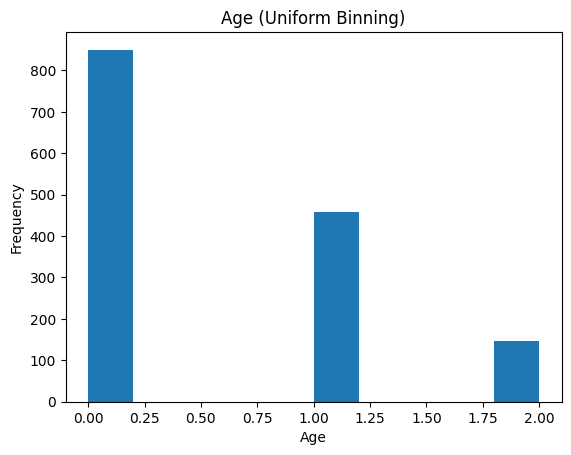

In [38]:
from sklearn.preprocessing import KBinsDiscretizer
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
binned_data = binner.fit_transform(covid_flu[["Age"]].dropna())
pd.Series(binned_data.reshape(-1,)).plot(title='Age (Uniform Binning)', kind='hist', xlabel='Age')

In [39]:
binned_data.reshape(-1)

array([2., 0., 0., ..., 0., 0., 0.])

Quantile bins are for equal height

<Axes: title={'center': 'Age (Quantile Binning)'}, xlabel='Age', ylabel='Frequency'>

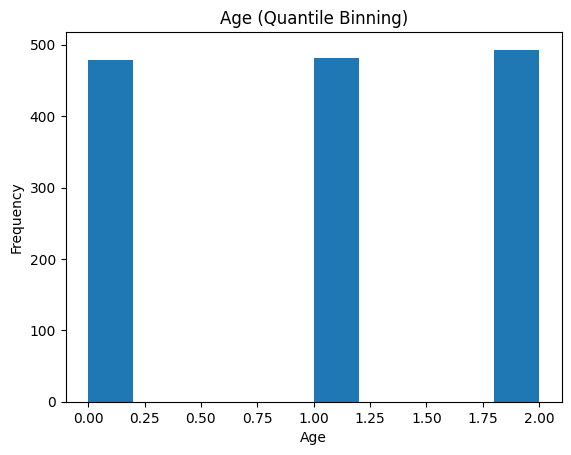

In [40]:
binner = KBinsDiscretizer(n_bins=3,encode='ordinal',strategy="quantile")
binned_data = binner.fit_transform(covid_flu[["Age"]].dropna())
pd.Series(binned_data.reshape(-1)).plot(title='Age (Quantile Binning)', kind='hist', xlabel='Age')

KMeans binning

<Axes: title={'center': 'Age (KMeans Binning)'}, xlabel='Age', ylabel='Frequency'>

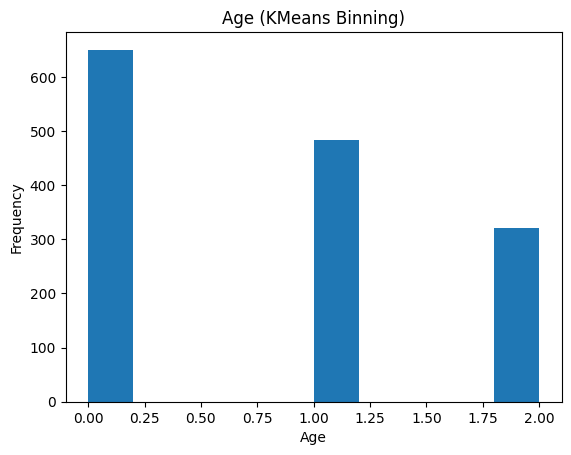

In [41]:
binner = KBinsDiscretizer(n_bins=3,encode='ordinal',strategy="kmeans")
binned_data = binner.fit_transform(covid_flu[["Age"]].dropna())
pd.Series(binned_data.reshape(-1)).plot(title='Age (KMeans Binning)', kind='hist', xlabel='Age')

#### One Hot Encodings

Custom One hot encoding for risk factors


In [44]:
covid_flu["RiskFactors"].nunique()

63

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer

class DummifyRiskFactor(BaseEstimator, TransformerMixin):

  def __init__(self):
    self.label_binarizer_ = None


  def parse_risk_factors(self, comma_sep_factors):
      try:
        return [s.strip().lower() for s in comma_sep_factors.split(',')]
      except:
          return [] #None

  def fit(self, X, y=None):
      self.label_binarizer_ = MultiLabelBinarizer()
      self.label_binarizer_.fit(X.apply(self.parse_risk_factors))
      return self

  def transform(self, X, y=None):
      return self.label_binarizer_.transform(X.apply(self.parse_risk_factors))




In [52]:
drf = DummifyRiskFactor()
risks = drf.fit_transform(covid_flu["RiskFactors"])
print(risks.shape)


(1482, 41)


In [53]:
pd.DataFrame(risks, columns=drf.label_binarizer_.classes_)

,asthma,athero,atopic dermatitis and repetitive respiratory infections,begin tumor (removed),chronic,chronic endrocrine disorder,chronic liver dieseas,chronic liver disorder,chronic neurological disorders,chronic obstructive pulmonary disease,...,lung disease,myxoma of abdominal cavity,obesity,pneumomediastinum and subcutaneous emphysema,pneumonia,pre-eclampsia,prom,renal disease,respiratory disease,rheumatoid arthritis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- In feature selection we will handle sparsity
- Also in custom transformer wwe fit to training data, so it comes across a feature not in the traning set in test set, it will throw it away

#### DOMAIN-SPECIFIC FEATURE CONSTRUCTION

Domain-Specific Feature Construction is highly advised as it tends to have more interpretable and useful features

In [54]:
covid_flu["FluSymptoms"] = covid_flu[['Diarrhea', 'Fever', 'Coughing', 'SoreThroat',
'NauseaVomitting', 'Fatigue']].sum(axis=1) >= 2

In [55]:
print(covid_flu['FluSymptoms'].value_counts())

FluSymptoms
False    753
True     729
Name: count, dtype: int64


In [56]:
print(covid_flu['FluSymptoms'].isnull().sum())

0


In [59]:
binary_features = ['Female', 'GroundGlassOpacity', 'CTscanResults','Diarrhea', 'Fever', 'FluSymptoms','Coughing', 'SoreThroat', 'NauseaVomitting','Fatigue', 'InitialPCRDiagnosis']

## Building feature engineering pipeline

### Train Test Spilt

In [57]:
from sklearn.model_selection import train_test_split
X,y = covid_flu.drop(["Diagnosis"], axis = 1), covid_flu["Diagnosis"]

x_train, x_test, y_train, y_test = train_test_split(
    X,y, stratify=y, random_state=0, test_size=0.2
)

In [58]:
x_train.shape

(1185, 20)

### Pipeline, Function Transformer and Feature Union

Creating a Feature Engineering Pipeline

In [64]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion



In [80]:
risk_factor_pipeline = Pipeline(
    [
        ('select_and_parse_risk_factor', FunctionTransformer(lambda df:df['RiskFactors'])),
        ('dummify', DummifyRiskFactor()),
    ]
)
risk_factor_pipeline.fit_transform(x_train, y_train).shape

(1185, 32)

In [79]:
binary_pipeline= Pipeline(
    [("select_categorical_features", FunctionTransformer(lambda df: df[binary_features])),
     ("fill_na",SimpleImputer(strategy="constant",fill_value=False))]
)
binary_pipeline.fit_transform(x_train, y_train).shape

(1185, 11)

In [78]:
numerical_pipeline = Pipeline(
    [
        ("Select_numerical_features",FunctionTransformer(lambda df: df[numerical_columns])),
        ("impute",SimpleImputer(strategy="median"))
    ]
)
numerical_pipeline.fit_transform(x_train, y_train).shape

(1185, 6)

In [73]:
simple_grid_search(x_train,y_train,x_test,y_test,numerical_pipeline)

Parsing took 0.01
Training time 13.78 seconds
              precision    recall  f1-score   support

     COVID19       0.78      0.72      0.75        82
        H1N1       0.90      0.92      0.91       215

    accuracy                           0.87       297
   macro avg       0.84      0.82      0.83       297
weighted avg       0.86      0.87      0.86       297

Overall data transforming and training time 13.816722869873047


ExtraTreesClassifier()

In [74]:
simple_grid_search(x_train,y_train,x_test,y_test,risk_factor_pipeline)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing took 0.02
Training time 20.05 seconds
              precision    recall  f1-score   support

     COVID19       0.80      0.10      0.17        82
        H1N1       0.74      0.99      0.85       215

    accuracy                           0.74       297
   macro avg       0.77      0.54      0.51       297
weighted avg       0.76      0.74      0.66       297

Overall data transforming and training time 20.074934005737305


ExtraTreesClassifier(n_estimators=50)

In [75]:
simple_grid_search(x_train,y_train,x_test,y_test,binary_pipeline)

Parsing took 0.04
Training time 14.76 seconds
              precision    recall  f1-score   support

     COVID19       0.78      0.61      0.68        82
        H1N1       0.86      0.93      0.90       215

    accuracy                           0.85       297
   macro avg       0.82      0.77      0.79       297
weighted avg       0.84      0.85      0.84       297

Overall data transforming and training time 14.773576021194458


ExtraTreesClassifier(max_depth=10, n_estimators=10)

Feature Union

In [76]:
simple_fe = FeatureUnion([
    ("risk_factors",risk_factor_pipeline),
    ("binary_pipline",binary_pipeline),
    ("numerical_pipeline",numerical_pipeline)
])

In [77]:
simple_fe.fit_transform(x_train,y_train).shape

(1185, 49)

In [81]:
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)
best_model

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing took 0.04
Training time 25.76 seconds
              precision    recall  f1-score   support

     COVID19       0.84      0.84      0.84        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.91       297
   macro avg       0.89      0.89      0.89       297
weighted avg       0.91      0.91      0.91       297

Overall data transforming and training time 25.837022304534912


ExtraTreesClassifier(n_estimators=500)

In [84]:
numerical_pipeline = Pipeline(
    [
        ("Select_numerical_features",FunctionTransformer(lambda df: df[numerical_columns])),
        ("impute",SimpleImputer(strategy="mean")),
        ("scale",StandardScaler())
    ]
)
simple_fe = FeatureUnion([
    ("risk_factors",risk_factor_pipeline),
    ("binary_pipline",binary_pipeline),
    ("numerical_pipeline",numerical_pipeline)
])

In [85]:
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing took 0.05
Training time 22.08 seconds
              precision    recall  f1-score   support

     COVID19       0.85      0.83      0.84        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.91       297
   macro avg       0.89      0.89      0.89       297
weighted avg       0.91      0.91      0.91       297

Overall data transforming and training time 22.1981098651886


- our missing values with an arbitrary 999
- then scaling

In [86]:
numerical_pipeline = Pipeline(
    [
        ("Select_numerical_features",FunctionTransformer(lambda df: df[numerical_columns])),
        ("impute",SimpleImputer(strategy="constant",fill_value=999)),
        ("scale",StandardScaler())
    ]
)
simple_fe = FeatureUnion([
    ("risk_factors",risk_factor_pipeline),
    ("binary_pipline",binary_pipeline),
    ("numerical_pipeline",numerical_pipeline)
])

In [87]:
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing took 0.07
Training time 18.70 seconds
              precision    recall  f1-score   support

     COVID19       0.88      0.87      0.87        82
        H1N1       0.95      0.95      0.95       215

    accuracy                           0.93       297
   macro avg       0.91      0.91      0.91       297
weighted avg       0.93      0.93      0.93       297

Overall data transforming and training time 18.722058296203613


- the Box-Cox transformation on our numerical
- then apply a Gaussian end-of-tail imputation,**bold text**

In [92]:
numerical_pipeline = Pipeline(
    [
        ("Select_numerical_features",FunctionTransformer(lambda df: df[numerical_columns])),
        ("Box-Cox",PowerTransformer(method="box-cox",standardize=True)),
        ("turn_into_df",FunctionTransformer(lambda matrix:pd.DataFrame(matrix))),
        ("end_of_tail",EndTailImputer(imputation_method="gaussian"))
    ]
)
simple_fe = FeatureUnion([
    ("risk_factors",risk_factor_pipeline),
    ("binary_pipline",binary_pipeline),
    ("numerical_pipeline",numerical_pipeline)
])

In [93]:
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing took 0.33
Training time 16.29 seconds
              precision    recall  f1-score   support

     COVID19       0.86      0.87      0.86        82
        H1N1       0.95      0.94      0.95       215

    accuracy                           0.92       297
   macro avg       0.90      0.91      0.90       297
weighted avg       0.92      0.92      0.92       297

Overall data transforming and training time 16.30758047103882


apply binning to our pipeline to see its effect

In [97]:
numerical_pipeline = Pipeline(
    [
        ("Select_numerical_features",FunctionTransformer(lambda df: df[numerical_columns])),
        ("Box-Cox",PowerTransformer(method="box-cox",standardize=True)),
        ("turn_into_df",FunctionTransformer(lambda matrix:pd.DataFrame(matrix))),
        ("end_of_tail",EndTailImputer(imputation_method="gaussian")),
        ('ordinal_bins',KBinsDiscretizer(n_bins=20,encode='ordinal'))
    ]
)
simple_fe = FeatureUnion([
    ("risk_factors",risk_factor_pipeline),
    ("binary_pipline",binary_pipeline),
    ("numerical_pipeline",numerical_pipeline)
])

In [98]:
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306

Parsing took 0.35
Training time 26.39 seconds
              precision    recall  f1-score   support

     COVID19       0.84      0.90      0.87        82
        H1N1       0.96      0.93      0.95       215

    accuracy                           0.93       297
   macro avg       0.90      0.92      0.91       297
weighted avg       0.93      0.93      0.93       297

Overall data transforming and training time 26.411267518997192


## Feature selection

Now let's select the most useful features, or try to identify them and select them

### Mutual information

- measure between two variables thqat measure the reduction in uncertainity of the first variable given that you know the second variable.
- use it for a feature wtr to label/target



In [100]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

risk_factor_pipeline = Pipeline(
    [
        ("select_risk_factor", FunctionTransformer(lambda df: df["RiskFactors"])),
        ("dummify",DummifyRiskFactor()),
        ("mutual_info", SelectKBest(mutual_info_classif, k = 20))
    ]
)

In [101]:
simple_fe = FeatureUnion([
    ("risk_factors",risk_factor_pipeline),
    ("binary_pipline",binary_pipeline),
    ("numerical_pipeline",numerical_pipeline)
])

In [102]:
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306

Parsing took 0.72
Training time 17.35 seconds
              precision    recall  f1-score   support

     COVID19       0.83      0.91      0.87        82
        H1N1       0.97      0.93      0.95       215

    accuracy                           0.93       297
   macro avg       0.90      0.92      0.91       297
weighted avg       0.93      0.93      0.93       297

Overall data transforming and training time 17.36291813850403


### Hypothesis testing

- feature selection is to utilize the chi-squared test
- we can use the chi-squared test to select features that the test deems the most dependent on the response, implying that it is useful in predicting the response variable.

In [103]:
from sklearn.feature_selection import chi2

risk_factor_pipeline = Pipeline(
    [
        ("select_risk_factor", FunctionTransformer(lambda df: df["RiskFactors"])),
        ("dummify", DummifyRiskFactor()),
        ("chi2",SelectKBest(chi2,k=20))
    ]
)

In [104]:
simple_fe = FeatureUnion([
    ("risk_factors",risk_factor_pipeline),
    ("binary_pipline",binary_pipeline),
    ("numerical_pipeline",numerical_pipeline)
])

In [105]:
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306

Parsing took 0.38
Training time 20.31 seconds
              precision    recall  f1-score   support

     COVID19       0.85      0.89      0.87        82
        H1N1       0.96      0.94      0.95       215

    accuracy                           0.93       297
   macro avg       0.90      0.91      0.91       297
weighted avg       0.93      0.93      0.93       297

Overall data transforming and training time 20.376850605010986


### Using machine learning

- last two feature selection methods had something in common,they operate independently on each feature
- they operate independently on each feature
- a secondary ML model that has either the feature_importances or the coef attribute and uses those values to select features

In [108]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

risk_factor_pipeline = Pipeline(
    [
        ("select_risk_factor", FunctionTransformer(lambda df:df["RiskFactors"])),
        ('dummify', DummifyRiskFactor()),
        ("tree_selector",SelectFromModel(max_features=30, estimator=DecisionTreeClassifier()))
    ]
)

In [109]:
simple_fe = FeatureUnion([
    ("risk_factors",risk_factor_pipeline),
    ("binary_pipline",binary_pipeline),
    ("numerical_pipeline",numerical_pipeline)
])

In [110]:
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306

Parsing took 0.39
Training time 23.31 seconds
              precision    recall  f1-score   support

     COVID19       0.84      0.90      0.87        82
        H1N1       0.96      0.93      0.95       215

    accuracy                           0.93       297
   macro avg       0.90      0.92      0.91       297
weighted avg       0.93      0.93      0.93       297

Overall data transforming and training time 23.31947898864746


In [112]:
from sklearn import set_config
set_config(display='diagram')
simple_fe.transformer_list

[('risk_factors',
  Pipeline(steps=[('select_risk_factor',
                   FunctionTransformer(func=<function <lambda> at 0x792723e75620>)),
                  ('dummify', DummifyRiskFactor()),
                  ('tree_selector',
                   SelectFromModel(estimator=DecisionTreeClassifier(),
                                   max_features=30))])),
 ('binary_pipline',
  Pipeline(steps=[('select_categorical_features',
                   FunctionTransformer(func=<function <lambda> at 0x792723e74860>)),
                  ('fill_na',
                   SimpleImputer(fill_value=False, strategy='constant'))])),
 ('numerical_pipeline',
  Pipeline(steps=[('Select_numerical_features',
                   FunctionTransformer(func=<function <lambda> at 0x792723e74c20>)),
                  ('Box-Cox', PowerTransformer(method='box-cox')),
                  ('turn_into_df',
                   FunctionTransformer(func=<function <lambda> at 0x792723e74fe0>)),
                  ('end_of_tail', 

In [113]:
%pip install graphviz


In [114]:
import graphviz

def visualize_union(union_object, name="My_Pipeline"):
    dot = graphviz.Digraph(name, comment='Feature Union Architecture')
    dot.attr(rankdir='LR', size='10,5') # Left to Right layout

    # Input Node
    dot.node('Input', 'Raw Data (DataFrame)', shape='box', style='filled', color='lightgrey')
    dot.node('Union', 'FeatureUnion', shape='diamond', style='filled', color='orange')

    # Add each branch from the transformer_list
    for step_name, transformer in union_object.transformer_list:
        dot.node(step_name, f"Branch: {step_name}\n({type(transformer).__name__})", shape='ellipse')
        dot.edge('Input', step_name)
        dot.edge(step_name, 'Union')

    # Output Node
    dot.node('Output', 'Concatenated Feature Vector', shape='box', style='filled', color='lightblue')
    dot.edge('Union', 'Output')

    return dot

# Usage:
# my_union = FeatureUnion(transformer_list=[('text', tfidf), ('num', scaler)])
diagram = visualize_union(simple_fe)
diagram.render('pipeline_diagram', format='png', cleanup=True)


'pipeline_diagram.png'

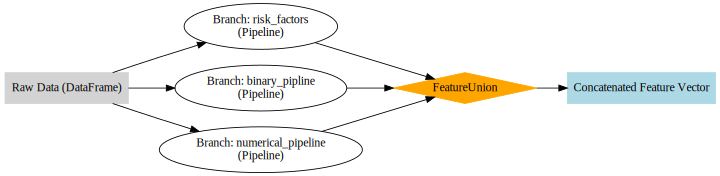

In [115]:
diagram

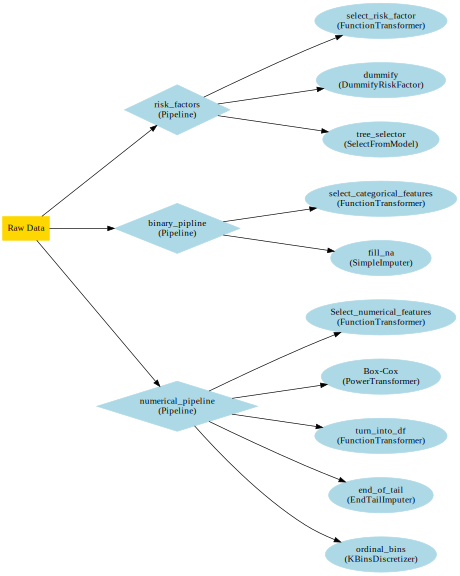

In [119]:
from sklearn.compose import ColumnTransformer

def visualize_complex_pipeline(pipeline_obj, name="Full_Project_Architecture"):
    dot = graphviz.Digraph(name, comment='Recursive Pipeline Map')
    dot.attr(rankdir='LR', size='12,8', nodesep='0.5', ranksep='1.0')

    # Track nodes to avoid duplicates
    seen_nodes = set()

    def add_steps(parent_node, current_obj, prefix=""):
        if isinstance(current_obj, (Pipeline, FeatureUnion, ColumnTransformer)):
            # Determine how to iterate over steps
            if isinstance(current_obj, Pipeline):
                steps = current_obj.steps # List of (name, obj)
                is_parallel = True
            elif isinstance(current_obj, FeatureUnion):
                steps = current_obj.transformer_list
                is_parallel = True
            else: # ColumnTransformer
                steps = [(name, trans) for name, trans, cols in current_obj.transformers_]
                is_parallel = True

            prev_node = parent_node

            for i, (step_name, transformer) in enumerate(steps):
                node_id = f"{prefix}_{step_name}_{i}"
                label = f"{step_name}\n({type(transformer).__name__})"

                # Style logic
                color = "lightblue" if is_parallel else "lightgrey"
                shape = "diamond" if isinstance(transformer, (Pipeline, FeatureUnion)) else "ellipse"

                dot.node(node_id, label, shape=shape, style='filled', color=color)

                # Routing logic
                if is_parallel:
                    dot.edge(parent_node, node_id)
                else:
                    dot.edge(prev_node, node_id)
                    prev_node = node_id

                # RECURSION: Go deeper into the nested pipeline
                add_steps(node_id, transformer, prefix=node_id)

    dot.node('Input', 'Raw Data', shape='box', style='filled', color='gold')
    add_steps('Input', pipeline_obj)

    return dot

# Usage:
diagram = visualize_complex_pipeline(simple_fe)
display(diagram)


**Summary**  
This script demonstrates **feature engineering techniques** on a **COVID-19 vs. Flu binary classification** dataset (`covid_flu.csv`). The goal is to predict `Diagnosis` (COVID-19 or H1N1/Flu) while systematically comparing different imputation, transformation, encoding, construction, and selection strategies. It uses modular `sklearn` pipelines + `FeatureUnion` to chain separate processing branches for numerical, binary/symptom, and multi-label risk-factor features. The core experiment loop (`simple_grid_search`) measures how different feature engineering choices affect training time, parsing time, and final classification performance (via grid-searched `ExtraTreesClassifier`).

The notebook follows a classic applied ML workflow: EDA → missing value strategies → numerical/categorical transformations → domain-inspired feature construction → pipeline composition → feature selection → performance comparison.

### All Steps Involved + Why They Were Done

1. **Data Loading & Quick Inspection**  
   - Read CSV, `head()`, `isnull().mean()`, `value_counts(normalize=True)`, `info()`.  
   **Why**: Assess class balance (~balanced), missing value severity, and data types.

2. **EDA & Initial Cleaning**  
   - Convert `Sex` → boolean `Female`.  
   - Replace "Yes"/"No" → `True`/`False` across symptom/risk columns.  
   - Inspect unique values in multi-value columns like `RiskFactors`.  
   **Why**: Make features binary/logical where appropriate; prepare multi-label parsing later.

3. **Missing Value Imputation Exploration (Numerical)**  
   - `SimpleImputer`: mean / median / constant (999) / most_frequent.  
   - `EndTailImputer` (gaussian tail — mean + 3×std).  
   **Why**: Compare simple univariate strategies vs. distribution-tail-aware imputation (useful for skewed lab values like `lymphocytes`).

4. **Missing Value Imputation Exploration (Categorical/Binary)**  
   - Most frequent category.  
   - Constant fill (`False`) — domain logic: absence of mention ≈ not present.  
   **Why**: Symptoms/risk factors are often sparsely recorded; assuming missing = absent is clinically reasonable.

5. **Numerical Feature Transformations**  
   - Log / log1p → reduce right skew (e.g., `lymphocytes`).  
   - `PowerTransformer(method="box-cox")` → make distributions closer to normal.  
   - `StandardScaler` / `MinMaxScaler`.  
   - `KBinsDiscretizer` (uniform / quantile / kmeans strategies).  
   **Why**: Stabilize variance, satisfy normality assumptions of some models, reduce outlier influence, or create ordinal features for tree-based models.

6. **Categorical / Multi-label Feature Construction**  
   - Custom `DummifyRiskFactor` transformer:  
     - Split comma-separated `RiskFactors` → list.  
     - `MultiLabelBinarizer` → one-hot per unique risk.  
   - Domain feature: `FluSymptoms` = at least 2 of {Diarrhea, Fever, Coughing, …}.  
   **Why**: Turn free-text-like risk string into usable binary columns; create clinically meaningful composite symptom score.

7. **Pipeline Architecture & Composition**  
   - Separate `Pipeline`s for:  
     – risk factors (parse → dummify)  
     – binary features (select → fill `False`)  
     – numerical features (select → impute → scale/transform/bin)  
   - Combine via `FeatureUnion`.  
   - Wrap selections/transforms in `FunctionTransformer` for column selection.  
   **Why**: Modular, parallel processing of different feature groups; easy to swap strategies and compare impact.

8. **Model Evaluation Loop (`simple_grid_search`)**  
   - Grid search over `ExtraTreesClassifier` (depth, n_estimators, criterion).  
   - Time parsing + fitting.  
   - Report classification metrics on test set.  
   **Why**: Quantify how much each feature engineering choice improves (or hurts) predictive performance and runtime.

9. **Feature Selection Experiments**  
   - `SelectKBest` + `mutual_info_classif` (information theoretic).  
   - `SelectKBest` + `chi2` (statistical dependence for non-negative features).  
   - `SelectFromModel` + tree feature importances.  
   **Why**: Reduce dimensionality (especially after risk-factor one-hot explosion), remove noise, and compare filter vs. embedded selection.

10. **Visualization Attempts**  
    - `graphviz` diagrams of `FeatureUnion` and nested pipelines.  
    **Why**: Understand and document complex pipeline structure.

### Packages / Modules / Techniques Used

| Package / Module                          | Class / Function / Technique                              | Why It Was Used |
|-------------------------------------------|------------------------------------------------------------|-----------------|
| **pandas**                                | `read_csv`, `select_dtypes`, `value_counts`, `replace`, `plot` | Data loading, type-based column selection, quick stats & visualization |
| **numpy**                                 | `log`, `log1p`                                             | Manual log transforms |
| **matplotlib.pyplot**                     | `hist`, `box`, `show`                                      | Distribution & outlier visualization |
| **time**                                  | `time.time()`                                              | Measure preprocessing + training runtime |
| **sklearn.model_selection**               | `train_test_split` (stratified), `GridSearchCV`            | Balanced split; hyperparameter tuning |
| **sklearn.ensemble**                      | `ExtraTreesClassifier`                                     | Fast tree-based model for benchmarking feature engineering |
| **sklearn.metrics**                       | `classification_report`                                    | Detailed precision/recall/F1 per class |
| **sklearn.pipeline**                      | `Pipeline`, `FeatureUnion`                                 | Chain & parallelize feature processing branches |
| **sklearn.compose**                       | `ColumnTransformer` (imported but not heavily used)        | Potential for column-based dispatching (shown in viz attempt) |
| **sklearn.preprocessing**                 | `SimpleImputer`, `StandardScaler`, `MinMaxScaler`, `PowerTransformer`, `KBinsDiscretizer`, `FunctionTransformer`, `MultiLabelBinarizer` | Imputation, scaling, power transforms, binning, column selection wrapper, multi-label encoding |
| **sklearn.feature_selection**             | `SelectKBest` (`mutual_info_classif`, `chi2`), `SelectFromModel` | Filter & embedded feature selection methods |
| **feature_engine**                        | `EndTailImputer`                                           | Gaussian tail imputation (distribution-aware missing value fill) |
| **sklearn.base**                          | `BaseEstimator`, `TransformerMixin`                        | Create custom compatible transformer `DummifyRiskFactor` |
| **graphviz**                              | `Digraph`                                                  | Visualize pipeline / FeatureUnion structure (nice-to-have) |

**Key Technique Highlights**  
- **FeatureUnion + multiple branch pipelines** — clean way to handle heterogeneous feature types (multi-label text, binary flags, lab numbers).  
- **Custom `DummifyRiskFactor`** — essential for turning comma-separated risk strings into usable features.  
- **Domain feature `FluSymptoms`** — example of high-value, interpretable manual engineering.  
- Systematic A/B testing of imputation + transformation choices via the same grid-search wrapper — shows practical impact on model quality and speed.

This notebook serves as a solid tutorial on building modular, comparable feature engineering pipelines for tabular healthcare data.